# Tesla Stock Price Forecasting: LSTM vs RNN Comparison

This notebook implements a comparative analysis of Long Short-Term Memory (LSTM) networks and Simple Recurrent Neural Networks (RNN) for predicting Tesla stock prices. The analysis includes data preprocessing, feature engineering, model training, evaluation, and forecasting.

The goal is to determine which model architecture performs better for this specific time series forecasting task and generate 30-day forecasts for Tesla stock.

## Libraries and Dependencies

This analysis uses the following libraries:

- **pandas & numpy**: For data manipulation and numerical operations
- **seaborn & matplotlib**: For data visualization and plotting
- **sklearn**: For data preprocessing, model evaluation metrics, and train-test splitting
- **tensorflow.keras**: For building and training deep learning models
- **time**: For measuring and comparing model training times
- **matplotlib.dates**: For handling date formatting in plots

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, SimpleRNN, Bidirectional
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import matplotlib.dates as mdates
import random
import os

## Data Preparation

The data preparation process includes:

1. **Loading the dataset**: Reading Tesla stock price data from CSV
2. **Preprocessing**: Converting data types, handling dates, and setting up the index
3. **Feature engineering**: 
   - Computing percentage changes in closing price
   - Calculating moving averages
4. **Sequence creation**: Converting time series data into supervised learning format
   - Each sequence of length 120 days becomes an input (X)
   - The next day becomes the target (y)
5. **Scaling**: Normalizing the data using MinMaxScaler to improve model training
6. **Train-test-validation split**: Dividing data into training, validation, and test sets

In [20]:
# -------------- Set Random Seeds --------------
seed = 42
def set_seeds(seed_value=seed):
    """Set seeds for reproducibility across all libraries"""
    # Python built-in random module
    random.seed(seed_value)
    
    # NumPy
    np.random.seed(seed_value)
    
    # TensorFlow
    tf.random.set_seed(seed_value)
    
    # Set Python hash seed
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    # Configure TensorFlow for deterministic operations
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    # Configure TensorFlow session
    try:
        tf.config.experimental.enable_op_determinism()
    except:
        # Older TensorFlow versions might not have this
        print("TensorFlow enable_op_determinism not available in this version")
    
    # For TensorFlow 2.x compatibility - don't use set_session which is deprecated
    if hasattr(tf, 'compat') and hasattr(tf.compat, 'v1'):
        # Try to set up the TF 1.x style configs (for older TF 2.x versions)
        try:
            tf.compat.v1.set_random_seed(seed_value)
            session_conf = tf.compat.v1.ConfigProto(
                intra_op_parallelism_threads=1,
                inter_op_parallelism_threads=1
            )
            # Only set session if the function exists
            if hasattr(tf.compat.v1.keras.backend, 'set_session'):
                sess = tf.compat.v1.Session(config=session_conf)
                tf.compat.v1.keras.backend.set_session(sess)
        except Exception as e:
            print(f"TF 1.x compatibility mode setting failed: {e}")
    
    print(f"All seeds set to {seed_value} for reproducibility")

# Set seeds at the very beginning
# set_seeds(seed)


# -------------- Data Loading Functions --------------
def load_data(file_path):
    """Load and preprocess the dataset"""
    # Mount Google Drive if in Colab
    try:
        from google.colab import drive
        drive.mount("/content/drive", force_remount=True)
        print("Google Drive mounted successfully")
    except:
        print("Not running in Google Colab or drive already mounted")

    # Load data
    df = pd.read_csv(file_path)
    df = df.drop([0, 1], axis=0).reset_index(drop=True)

    # Convert columns to float
    for col in df.columns[1:]:
        df[col] = df[col].apply(lambda x: float(x))

    # Rename columns to lowercase
    df.columns = df.columns.str.lower()

    # Fix date column
    df['date'] = pd.to_datetime(df['price'])
    df.drop(['price'], inplace=True, axis=1)

    # Set date as index
    df.set_index('date', inplace=True)

    return df

# -------------- Feature Engineering --------------
def calculate_pct_change(df):
    """Calculate percentage change in closing price"""
    pct_change = []
    pct_change.append(0)
    for i in range(1, df.shape[0]):
        value = (df['close'][i] - df['close'][i-1])*100/df['close'][i-1]
        pct_change.append(value)

    return np.array(pct_change)

def calculate_moving_average(data, n_steps=15):
    """Calculate moving average of a time series"""
    ma = [0] * n_steps
    for i in range(n_steps, data.shape[0]):
        ma_val = np.mean(data.iloc[i - n_steps + 1: i+1])
        ma.append(ma_val)
    return np.array(ma)


# Function to calculate RSI
def calculate_rsi(data, window=14):
    """Calculate Relative Strength Index (RSI)"""
    # Calculate price changes
    delta = data.diff()
    
    # Create gain (up) and loss (down) series
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    # Calculate average gain and average loss
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    # Calculate relative strength
    rs = avg_gain / avg_loss
    
    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    
    # Fill NaN values
    rsi[:window] = 50  # Fill initial NaN values with neutral RSI
    
    return rsi


# -------------- Sequence Creation --------------
def create_sequences(data, seq_length):
    """Create sequences for LSTM model"""
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Shape = (batch size, sequence length, features)
        y.append(data[i+seq_length])    # Next row as prediction target
    return np.array(X), np.array(y)


def calculate_hurst_exponent(time_series, max_lag=100):
    """
    Calculate the Hurst exponent for a time series.
    
    Parameters:
    - time_series: The time series data (pandas Series or numpy array)
    - max_lag: Maximum lag to use for calculation
    
    Returns:
    - hurst_exponent: The calculated Hurst exponent
    - lags: The lag values used
    - rs_values: The rescaled range values
    """
    tau = []
    lagvec = []
    
    # Convert to numpy array if not already
    if isinstance(time_series, pd.Series):
        time_series = time_series.values
    
    # Step through different lag values
    for lag in range(2, max_lag):
        # Skip if lag is too large for the time series
        if lag >= len(time_series):
            break
            
        # Calculate price difference
        pp = np.array(time_series[lag:]) - np.array(time_series[:-lag])
        
        # Calculate mean and standard deviation
        mean_pp = np.mean(pp)
        sigma_pp = np.std(pp)
        
        # Skip if standard deviation is zero
        if sigma_pp == 0:
            continue
            
        # Calculate the rescaled range
        xpp = np.cumsum(pp - mean_pp)
        r = np.max(xpp) - np.min(xpp)
        s = sigma_pp
        
        # Skip if s is zero
        if s == 0:
            continue
            
        tau.append(r / s)
        lagvec.append(lag)
    
    # Convert lists to numpy arrays
    lags = np.array(lagvec)
    rs_values = np.array(tau)
    
    # Calculate Hurst exponent using linear regression
    if len(lags) > 0 and len(rs_values) > 0:
        m = np.polyfit(np.log10(lags), np.log10(rs_values), 1)
        hurst_exponent = m[0]
        return hurst_exponent, lags, rs_values
    else:
        return None, None, None


## Model Architecture

### LSTM Model

Long Short-Term Memory networks are specialized RNNs designed to capture long-term dependencies in sequential data:


In [21]:

# -------------- Model Building --------------
def build_lstm_model(input_shape, units=100):
    """Build LSTM model architecture"""
    set_seeds(seed)
    model = Sequential()
    model.add(Input(shape=input_shape))
    # model.add((LSTM(units=units, return_sequences=True)))
    # model.add(Dropout(0.2))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=input_shape[1]))

    model.compile(optimizer='Adam', loss='mean_squared_error')
    return model

def build_rnn_model(input_shape, units=100):
    """Build Vanilla RNN model architecture with the same structure as LSTM"""
    set_seeds(seed)
    model = Sequential()
    model.add(Input(shape=input_shape))
    # model.add(SimpleRNN(units=units, return_sequences=True))
    # model.add(Dropout(0.2))
    model.add(SimpleRNN(units=units, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=input_shape[1]))

    model.compile(optimizer='Adam', loss='mean_squared_error')
    return model


### 5. Forecasting Methodology

```markdown
## Forecasting Methodology

This analysis implements recursive multi-step forecasting:

1. Start with the last known sequence of actual data (120 days)
2. Make a prediction for the next day (t+1)
3. Shift the window forward by removing the oldest day (t-120)
4. Add the new prediction to the end of the window
5. Use this updated window to predict the next day (t+2)
6. Repeat steps 3-5 for the desired forecast horizon (30 days)

This approach allows for generating predictions beyond the available data, but can suffer from error accumulation over longer horizons as each prediction builds on previous predictions.

In [22]:
# -------------- Forecasting Function --------------
def forecast_future(model, last_sequence, scaler, days_to_predict, seq_length, feature_count, start_date):
    """Generate future forecasts based on the model"""
    # Create array to store predictions
    forecasted_values = np.empty((days_to_predict, feature_count))

    # Create window for recursive prediction
    window = np.empty((days_to_predict, seq_length, feature_count))

    # Initial window from last sequence of actual data
    window[0, :, :] = last_sequence

    # First prediction
    to_predict = window[0, :, :].reshape(1, seq_length, feature_count)
    forecasted_values[0, :] = model.predict(to_predict, verbose=False)

    # Subsequent predictions
    for i in range(1, days_to_predict):
        window[i, :-1, :] = window[i-1, 1:, :]  # Remove first row of previous window
        window[i, -1, :] = forecasted_values[i-1, :]  # Add previous prediction
        to_predict = window[i, :, :].reshape(1, seq_length, feature_count)
        forecasted_values[i, :] = model.predict(to_predict, verbose=False)

    # Inverse transform scaled predictions
    forecasted_values = scaler.inverse_transform(forecasted_values)

    # Create DataFrame with date index
    forecast_index = pd.date_range(start=start_date, periods=days_to_predict, freq='B')
    forecasted_df = pd.DataFrame(forecasted_values, index=forecast_index)

    return forecasted_df

## Evaluation Metrics

The models are evaluated using multiple performance metrics:

- **Mean Squared Error (MSE)**: Average of squared differences between predictions and actual values
- **Root Mean Squared Error (RMSE)**: Square root of MSE, providing error in the same units as the target variable
- **Mean Absolute Error (MAE)**: Average of absolute differences between predictions and actual values
- **R² Score**: Proportion of variance in the dependent variable explained by the model
- **Mean Absolute Percentage Error (MAPE)**: Average percentage difference between predictions and actual values

These metrics provide a comprehensive view of model performance from different perspectives.

In [23]:


# -------------- Performance Metrics --------------
def calculate_metrics(y_true, y_pred):
    """Calculate various performance metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape
    }

## Visualization Functions

Multiple visualization functions help analyze and compare the models:

1. **Data Exploration**:
   - `plot_percentage_change()`: Visualizes daily price changes and their distribution
   - `plot_stock_with_ma()`: Shows stock price with moving average and volume
   - `plot_volatility_analysis()`: Examines price volatility over time
   - `plot_candlestick_chart()`: Traditional OHLC financial chart

2. **Model Comparison**:
   - `plot_model_comparison()`: Compares predictions against actual prices
   - `plot_error_comparison()`: Analyzes prediction errors for both models
   - `plot_close_predictions_detail()`: Detailed view of recent predictions
   - `plot_forecast_comparison()`: Compares future forecasts from both models
   - `plot_training_history()`: Visualizes training and validation loss curves
   - `compare_model_metrics()`: Side-by-side comparison of performance metrics

In [24]:


# -------------- Visualization Functions --------------
def plot_percentage_change(df_index, pct_change):
    """Plot percentage change in closing price"""
    plt.figure(figsize=(20, 6))
    sns.lineplot(x=df_index, y=pct_change)
    plt.xlabel('Year')
    plt.ylabel('Percentage Change (%)')
    plt.title('Percentage Change in Tesla Stock Price')
    plt.grid(True)
    plt.show()

    # Plot distribution of percentage changes
    plt.figure(figsize=(12, 6))
    sns.histplot(x=pct_change, bins=100, kde=True)
    plt.title(f"Distribution of Percentage Changes (Mean: {pct_change.mean():.4f}%)")
    plt.axvline(pct_change.mean(), color='r', linestyle='--')
    plt.show()

def plot_stock_with_ma(df, ma, n_steps):
    """Plot stock price with moving average and volume"""
    plt.figure(figsize=(20, 6))
    plt.plot(df.index, df['close'], 'b-', label='Close Price')
    plt.bar(df.index, df['volume']/3e6, alpha=0.3, label='Volume (scaled)')
    plt.plot(df.index[n_steps:], ma[n_steps:], 'r', label=f'{n_steps}-day Moving Avg')
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.title("Tesla Stock Price with Moving Average and Volume")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_model_comparison(df, lstm_pred, rnn_pred, lstm_forecast=None, rnn_forecast=None):
    """Plot LSTM vs RNN predictions and forecasts"""
    plt.figure(figsize=(20, 10))

    # Plot actual values
    plt.plot(df.index, df['close'], 'k-', label='Actual', linewidth=2)

    # Plot LSTM and RNN predictions
    plt.plot(lstm_pred.index, lstm_pred['close'], 'b-', label='LSTM Predicted', alpha=0.8)
    plt.plot(rnn_pred.index, rnn_pred['close'], 'g-', label='RNN Predicted', alpha=0.8)

    # Plot forecasts if provided
    if lstm_forecast is not None and rnn_forecast is not None:
        plt.axvline(x=lstm_forecast.index[0], color='k', linestyle='--', label='Forecast Start')
        plt.plot(lstm_forecast.index, lstm_forecast['close'], 'b--', label='LSTM Forecast')
        plt.plot(rnn_forecast.index, rnn_forecast['close'], 'g--', label='RNN Forecast')

    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.title('Tesla Stock Price: LSTM vs RNN Comparison')
    plt.legend()
    plt.show()

def plot_error_comparison(df, lstm_pred, rnn_pred):
    """Plot error comparison between LSTM and RNN"""
    # Calculate errors
    lstm_error = lstm_pred['close'] - df.loc[lstm_pred.index, 'close']
    rnn_error = rnn_pred['close'] - df.loc[rnn_pred.index, 'close']

    plt.figure(figsize=(20, 12))

    # Plot 1: Absolute errors
    plt.subplot(2, 1, 1)
    plt.plot(lstm_pred.index, np.abs(lstm_error), 'b-', label='LSTM |Error|')
    plt.plot(rnn_pred.index, np.abs(rnn_error), 'g-', label='RNN |Error|')
    plt.title('Absolute Prediction Errors: LSTM vs RNN')
    plt.ylabel('Absolute Error ($)')
    plt.legend()
    plt.grid(True)

    # Plot 2: Error distributions
    plt.subplot(2, 1, 2)
    plt.hist(lstm_error, bins=50, alpha=0.5, label='LSTM Error', color='blue')
    plt.hist(rnn_error, bins=50, alpha=0.5, label='RNN Error', color='green')
    plt.axvline(lstm_error.mean(), color='blue', linestyle='--', label=f'LSTM Mean Error: {lstm_error.mean():.2f}')
    plt.axvline(rnn_error.mean(), color='green', linestyle='--', label=f'RNN Mean Error: {rnn_error.mean():.2f}')
    plt.title('Error Distribution: LSTM vs RNN')
    plt.xlabel('Error ($)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_close_predictions_detail(df, lstm_pred, rnn_pred, window_size=30):
    """Plot detailed close price predictions for the last window_size days"""
    # Get the last window_size days
    last_days = df.index[-window_size:]

    # Filter predictions for those days
    lstm_last = lstm_pred.loc[lstm_pred.index.isin(last_days)]
    rnn_last = rnn_pred.loc[rnn_pred.index.isin(last_days)]
    actual_last = df.loc[last_days]

    plt.figure(figsize=(20, 8))
    plt.plot(actual_last.index, actual_last['close'], 'ko-', label='Actual', linewidth=2)
    plt.plot(lstm_last.index, lstm_last['close'], 'bs-', label='LSTM', markersize=8)
    plt.plot(rnn_last.index, rnn_last['close'], 'g^-', label='RNN', markersize=8)

    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.title(f'Detailed Comparison of Last {window_size} Days Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_forecast_comparison(lstm_forecast, rnn_forecast):
    """Plot detailed comparison of LSTM and RNN forecasts"""
    plt.figure(figsize=(20, 8))

    plt.plot(lstm_forecast.index, lstm_forecast['close'], 'b-o', label='LSTM Forecast')
    plt.plot(rnn_forecast.index, rnn_forecast['close'], 'g-^', label='RNN Forecast')

    # Calculate the difference between forecasts
    diff = lstm_forecast['close'] - rnn_forecast['close']

    # Plot the difference as a bar chart on a secondary axis
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax2.bar(lstm_forecast.index, diff, alpha=0.3, color='r', label='LSTM - RNN')
    ax2.set_ylabel('Difference ($)')

    # Add grid and labels
    plt.grid(True)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price ($)')
    plt.title('Forecast Comparison: LSTM vs RNN')

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_training_history(lstm_history, rnn_history):
    """Plot training and validation loss history for both models"""
    plt.figure(figsize=(15, 10))

    # Plot training losses
    plt.subplot(2, 1, 1)
    plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
    plt.plot(rnn_history.history['loss'], label='RNN Training Loss')
    plt.title('Training Loss: LSTM vs RNN')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')  # Log scale often helps visualize the convergence better

    # Plot validation losses
    plt.subplot(2, 1, 2)
    plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
    plt.plot(rnn_history.history['val_loss'], label='RNN Validation Loss')
    plt.title('Validation Loss: LSTM vs RNN')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

def plot_individual_training_history(lstm_history, rnn_history):
    """Plot separate training and validation loss charts for each model"""
    # LSTM Loss Plot
    plt.figure(figsize=(15, 6))
    plt.plot(lstm_history.history['loss'], label='Training Loss')
    plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Model: Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

    # RNN Loss Plot
    plt.figure(figsize=(15, 6))
    plt.plot(rnn_history.history['loss'], label='Training Loss')
    plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
    plt.title('RNN Model: Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

def plot_volatility_analysis(df):
    """Plot volatility analysis over time"""
    # Calculate rolling standard deviation (volatility)
    volatility = df['close'].rolling(window=20).std()

    plt.figure(figsize=(20, 10))

    # Plot 1: Stock Price
    plt.subplot(2, 1, 1)
    plt.plot(df.index, df['close'], label='Close Price')
    plt.title('Tesla Stock Price')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)

    # Plot 2: Volatility
    plt.subplot(2, 1, 2)
    plt.plot(df.index, volatility, color='red', label='20-day Volatility')
    plt.title('Tesla Stock Price Volatility (20-day Rolling Std)')
    plt.xlabel('Date')
    plt.ylabel('Volatility ($)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_candlestick_chart(df, days=90):
    """Plot candlestick chart for the last n days"""
    # Get last n days of data
    data = df.tail(days)

    fig, ax = plt.subplots(figsize=(20, 10))

    # Calculate the distance between points for width of candlesticks
    width = 0.6

    # Create candlestick colors
    up = data[data.close >= data.open]
    down = data[data.close < data.open]

    # Plot candlesticks
    ax.bar(up.index, up.close-up.open, width, bottom=up.open, color='green', alpha=0.5)
    ax.bar(down.index, down.close-down.open, width, bottom=down.open, color='red', alpha=0.5)

    # Plot high-low lines
    ax.vlines(up.index, up.low, up.high, color='green', linewidth=1)
    ax.vlines(down.index, down.low, down.high, color='red', linewidth=1)

    plt.title(f'Tesla Stock - Candlestick Chart (Last {days} Trading Days)')
    plt.ylabel('Price ($)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def compare_model_metrics(metrics_lstm, metrics_rnn):
    """Compare model metrics side by side"""
    metrics = pd.DataFrame({
        'LSTM': metrics_lstm,
        'RNN': metrics_rnn
    })

    plt.figure(figsize=(12, 8))

    # Plot the metrics as a bar chart
    ax = metrics.plot(kind='bar', color=['blue', 'green'], alpha=0.7)

    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f')

    plt.title('Model Performance Metrics: LSTM vs RNN')
    plt.ylabel('Value')
    plt.xlabel('Metric')
    plt.grid(axis='y')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print the metrics table
    print("\n--- Model Performance Comparison ---")
    print(metrics)

    # Calculate improvement percentages
    improvement = ((metrics['RNN'] - metrics['LSTM']) / metrics['RNN'] * 100).abs()
    better_model = ['LSTM' if metrics['LSTM'][i] < metrics['RNN'][i] else 'RNN' for i in range(len(metrics))]

    # For R², higher is better
    if 'R²' in metrics.index:
        idx = metrics.index.get_loc('R²')
        better_model[idx] = 'LSTM' if metrics['LSTM'][idx] > metrics['RNN'][idx] else 'RNN'

    comparison = pd.DataFrame({
        'LSTM': metrics['LSTM'],
        'RNN': metrics['RNN'],
        'Improvement (%)': improvement,
        'Better Model': better_model
    })

    print("\n--- Detailed Comparison ---")
    print(comparison)


def plot_stock_with_ma_rsi(df, ma, n_steps, rsi):
    """Plot stock price with moving average, volume and RSI"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), gridspec_kw={'height_ratios': [3, 1]})
    
    # Top plot: Price, Volume, and MA
    ax1.plot(df.index, df['close'], 'b-', label='Close Price')
    ax1.bar(df.index, df['volume']/3e6, alpha=0.3, label='Volume (scaled)')
    ax1.plot(df.index[n_steps:], ma[n_steps:], 'r', label=f'{n_steps}-day Moving Avg')
    ax1.set_ylabel("Price ($)")
    ax1.set_title("Tesla Stock Price with Moving Average, Volume, and RSI")
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    # Bottom plot: RSI
    ax2.plot(df.index, rsi, 'g-', label='RSI')
    ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5)
    ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5)
    ax2.set_ylim(0, 100)
    ax2.fill_between(df.index, rsi, 70, where=(rsi>=70), color='r', alpha=0.3)
    ax2.fill_between(df.index, rsi, 30, where=(rsi<=30), color='g', alpha=0.3)
    ax2.set_ylabel("RSI")
    ax2.set_xlabel("Date")
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


def plot_hurst_exponent(df, hurst_exponent, lags, rs_values):
    """Plot Hurst exponent analysis"""
    plt.figure(figsize=(20, 10))
    
    # Plot 1: Stock Price
    plt.subplot(2, 1, 1)
    plt.plot(df.index, df['close'], label='Close Price')
    plt.title(f'Tesla Stock Price with Hurst Exponent = {hurst_exponent:.4f}')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Rescaled Range Analysis
    plt.subplot(2, 1, 2)
    plt.loglog(lags, rs_values, 'o', markersize=5)
    
    # Add regression line
    reg_line = 10**(np.polyval(np.polyfit(np.log10(lags), np.log10(rs_values), 1), np.log10(lags)))
    plt.loglog(lags, reg_line, 'r-', linewidth=2)
    
    plt.title(f'Rescaled Range Analysis (H = {hurst_exponent:.4f})')
    plt.xlabel('Lag')
    plt.ylabel('Rescaled Range (R/S)')
    plt.grid(True, which="both", ls="-")
    
    # Add interpretation
    if hurst_exponent < 0.5:
        interpretation = "Mean-reverting (anti-persistent) series"
    elif hurst_exponent > 0.5:
        interpretation = "Trend-following (persistent) series"
    else:
        interpretation = "Random Walk"
    
    plt.figtext(0.5, 0.01, f"Interpretation: {interpretation}", ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()



# Defining Variables

In [25]:
set_seeds(seed)
file_path = "/kaggle/input/tesla-stock-price-data-2000-2025/tesla_stock_data_2000_2025.csv"
seq_length = 180
units = 20
batch_size = 32
epochs = 25
days_to_predict = 30
test_size = 0.15
validation_size = 0.15  
n_steps_ma = 10

All seeds set to 42 for reproducibility


# Loading Data

In [26]:
# Load data
df = load_data(file_path)
print("Data loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(df.head())

print("\n--- Data Statistics ---")
print(df.drop(['date'], axis=1, errors='ignore').describe())

Not running in Google Colab or drive already mounted
Data loaded successfully!
Dataset shape: (3692, 5)
               close      high       low      open       volume
date                                                           
2010-06-29  1.592667  1.666667  1.169333  1.266667  281494500.0
2010-06-30  1.588667  2.028000  1.553333  1.719333  257806500.0
2010-07-01  1.464000  1.728000  1.351333  1.666667  123282000.0
2010-07-02  1.280000  1.540000  1.247333  1.533333   77097000.0
2010-07-06  1.074000  1.333333  1.055333  1.333333  103003500.0

--- Data Statistics ---
             close         high          low         open        volume
count  3692.000000  3692.000000  3692.000000  3692.000000  3.692000e+03
mean     84.684063    86.583019    82.720395    84.724803  9.647972e+07
std     111.289879   113.897252   108.647448   111.413059  7.736170e+07
min       1.053333     1.108667     0.998667     1.076000  1.777500e+06
25%      12.226501    12.447833    12.011500    12.238833  4.93

# Calculate percent change in prices

/tmp/ipykernel_31/3008950739.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value = (df['close'][i] - df['close'][i-1])*100/df['close'][i-1]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


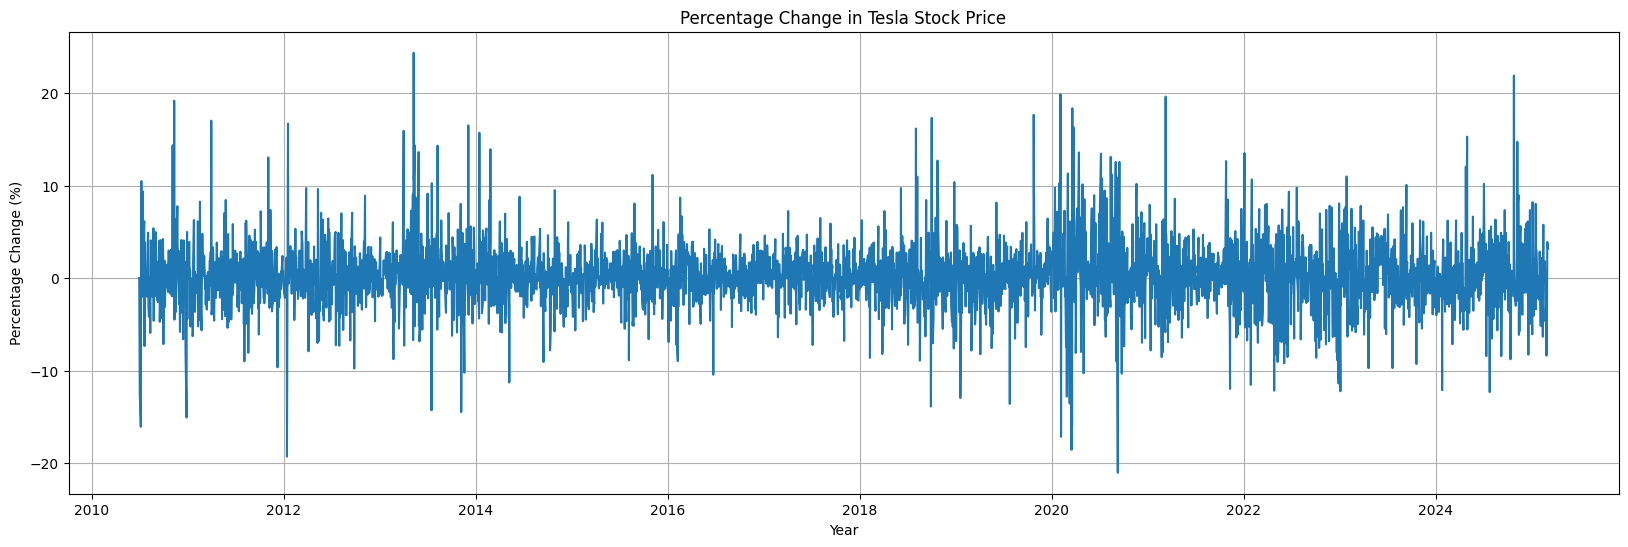

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


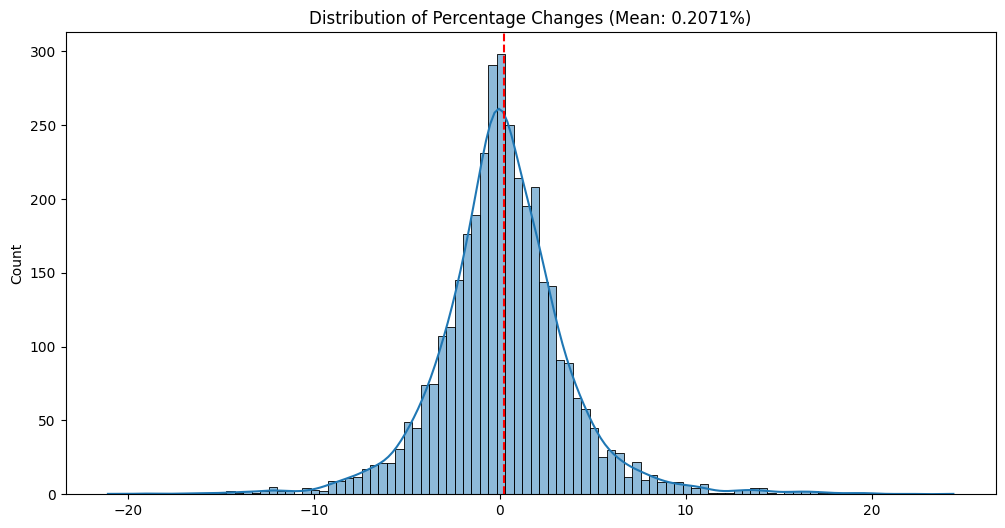

In [27]:
# Calculate and plot percentage change
pct_change = calculate_pct_change(df)
plot_percentage_change(df.index, pct_change)

# Plotting Indicators

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


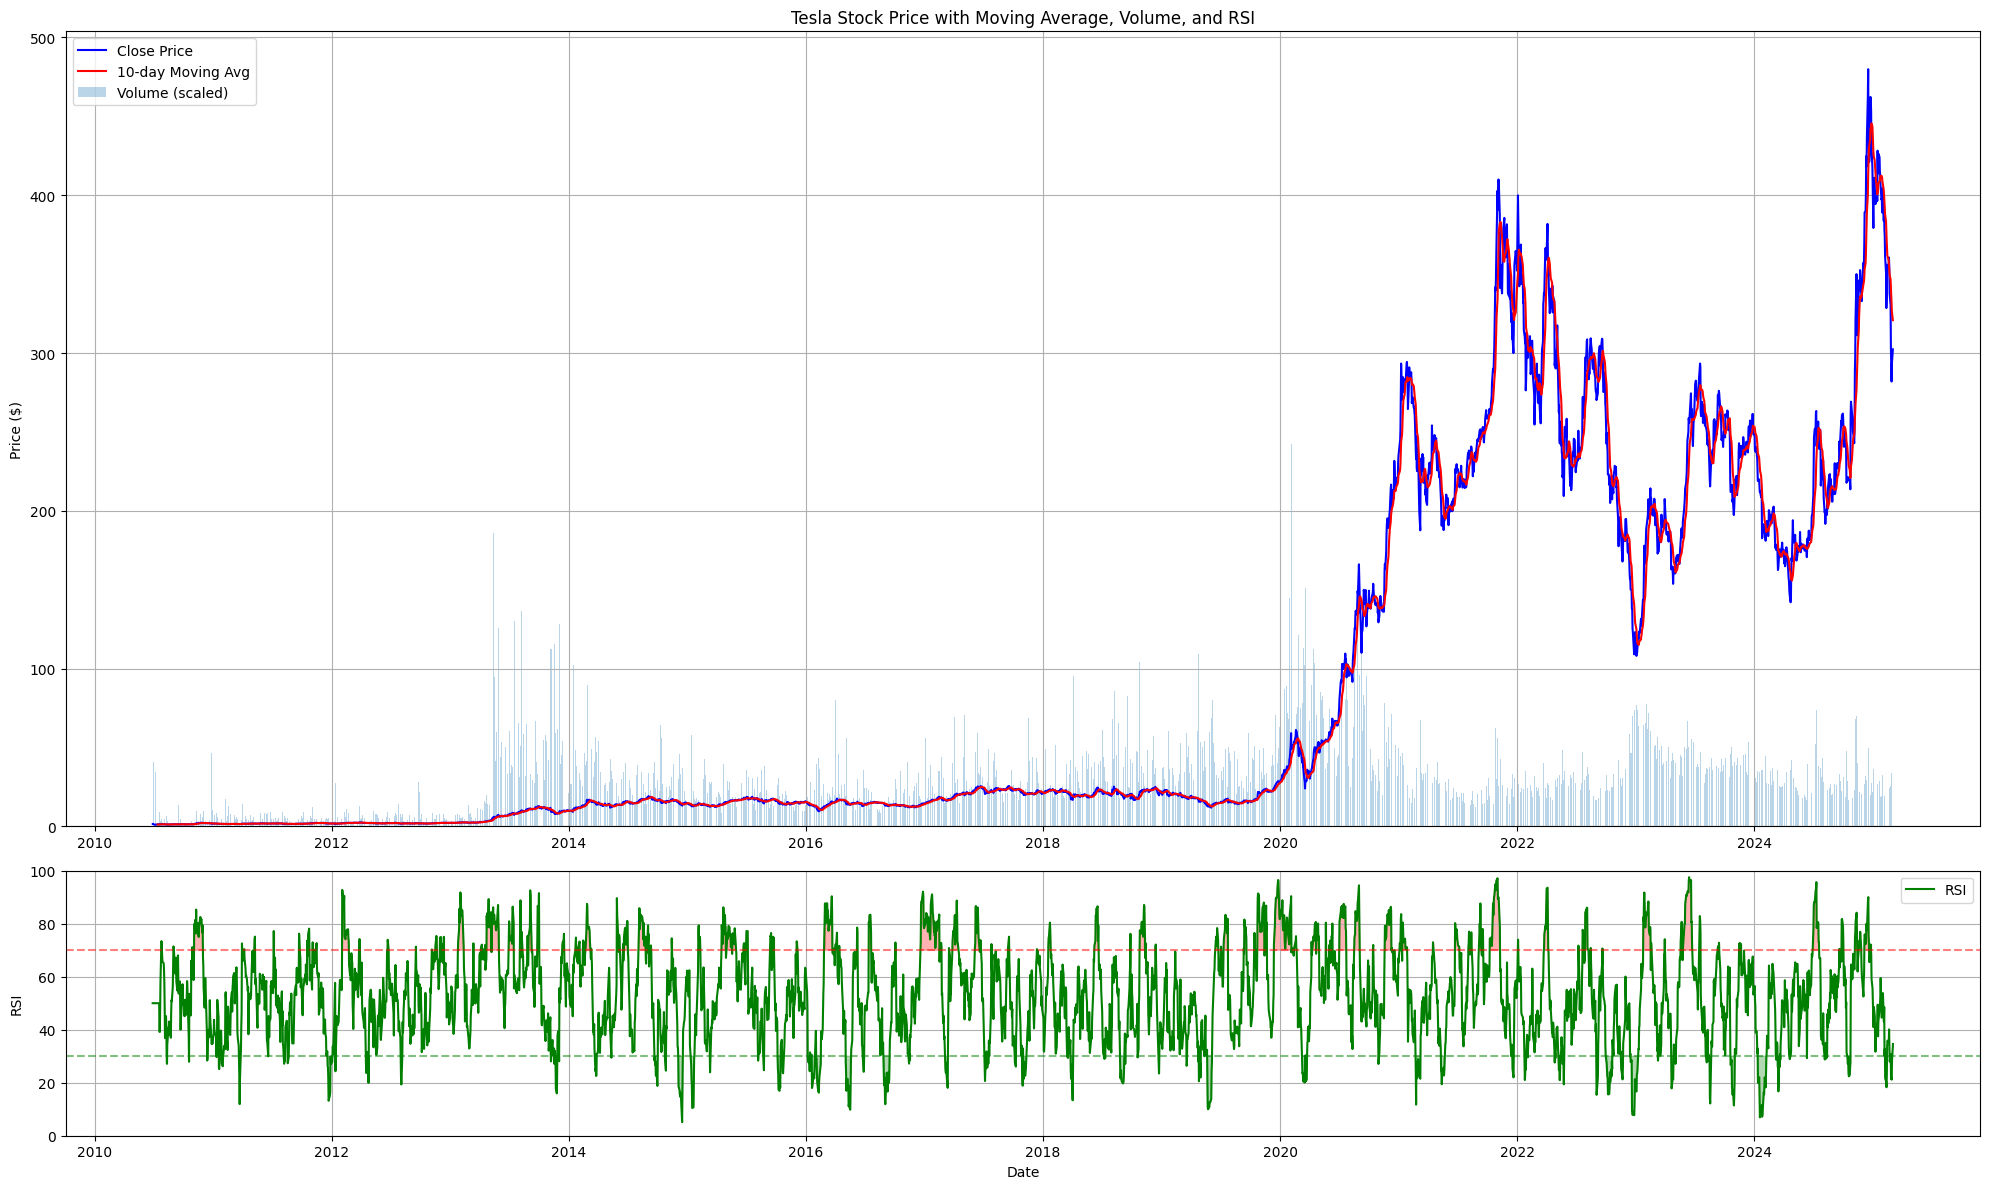

In [28]:
# Calculate RSI
rsi = calculate_rsi(df['close'], window=14)

# Calculate and plot moving average
ma = calculate_moving_average(df['close'], n_steps=n_steps_ma)
# plot_stock_with_ma(df, ma, n_steps_ma)
# Plot stock with MA and RSI
plot_stock_with_ma_rsi(df, ma, n_steps_ma, rsi)

# Additional Plots

# Hurst Exponent
``` markdown
Hurst Exponent helps you understand if a time series, like stock prices, 
exhibits a tendency to trend, revert to its mean, or follow a random walk

H < 0.5: Mean-reverting (anti-persistent) series
H = 0.5: Random walk (uncorrelated)
H > 0.5: Trend-following (persistent) series

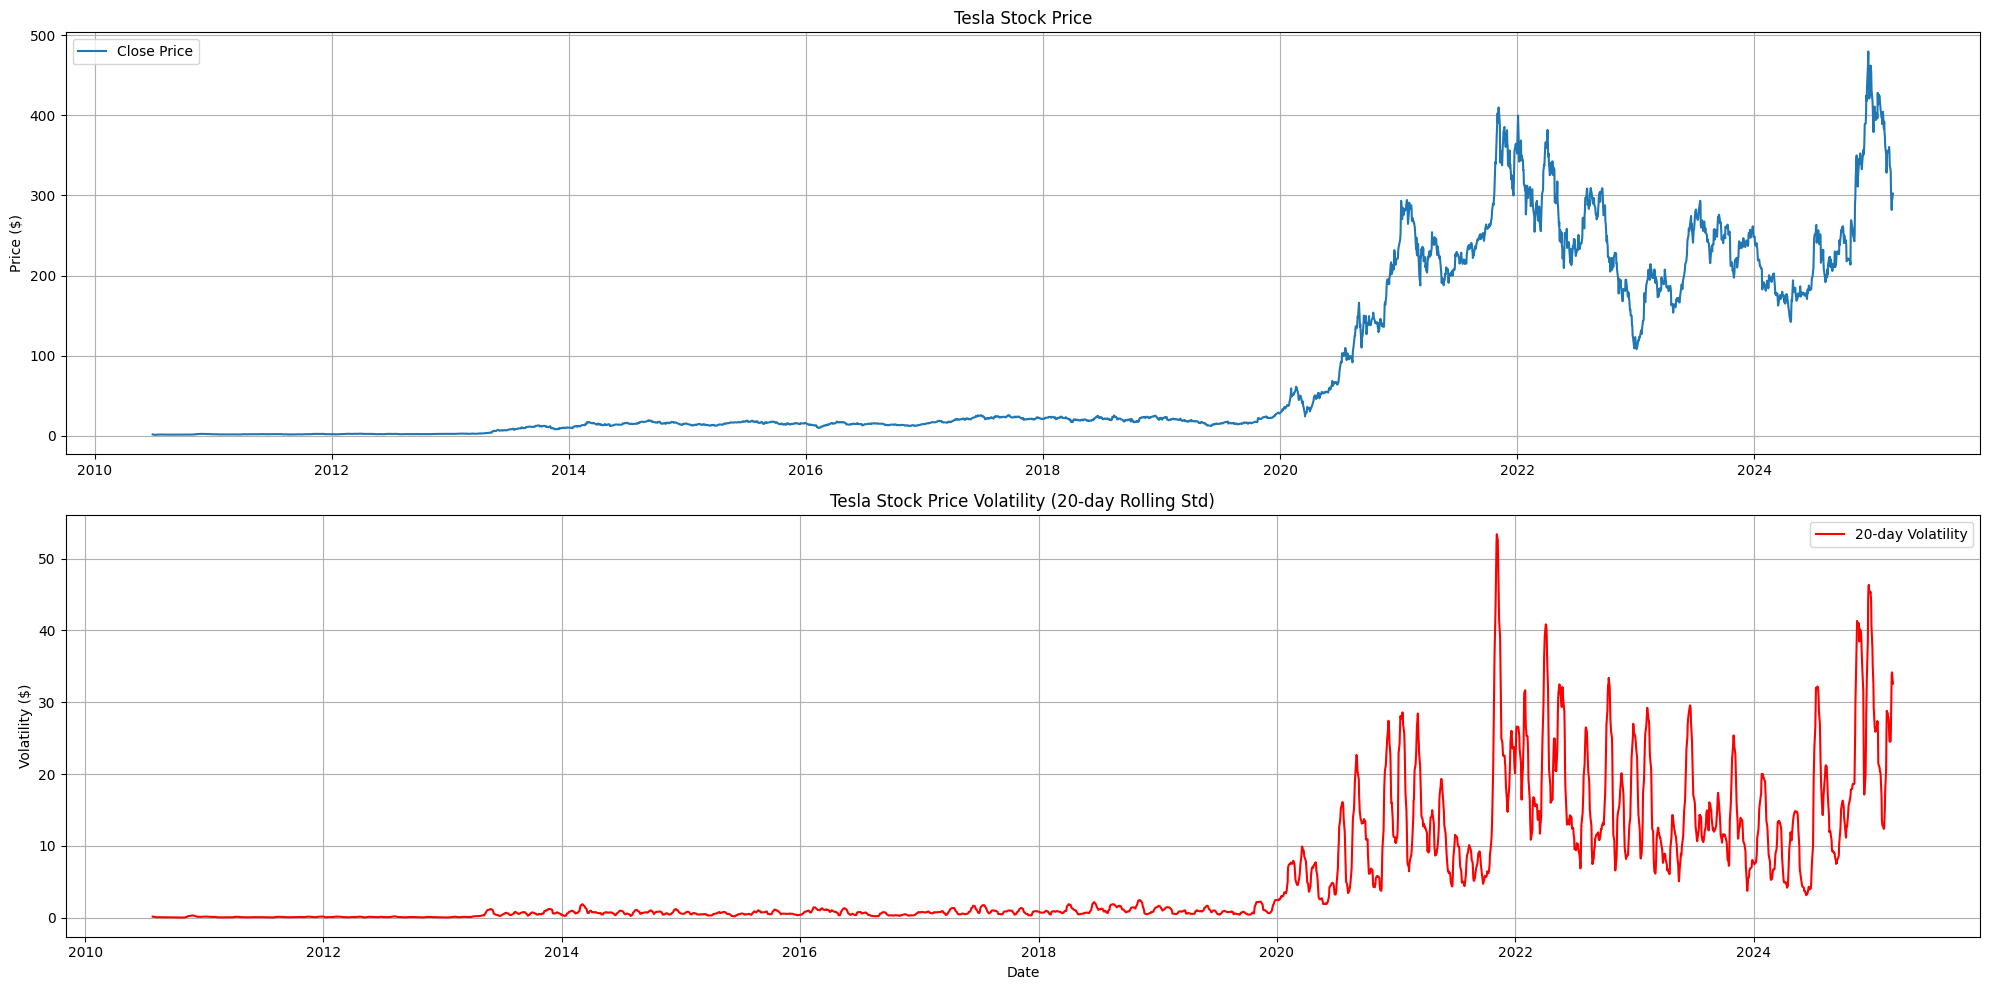

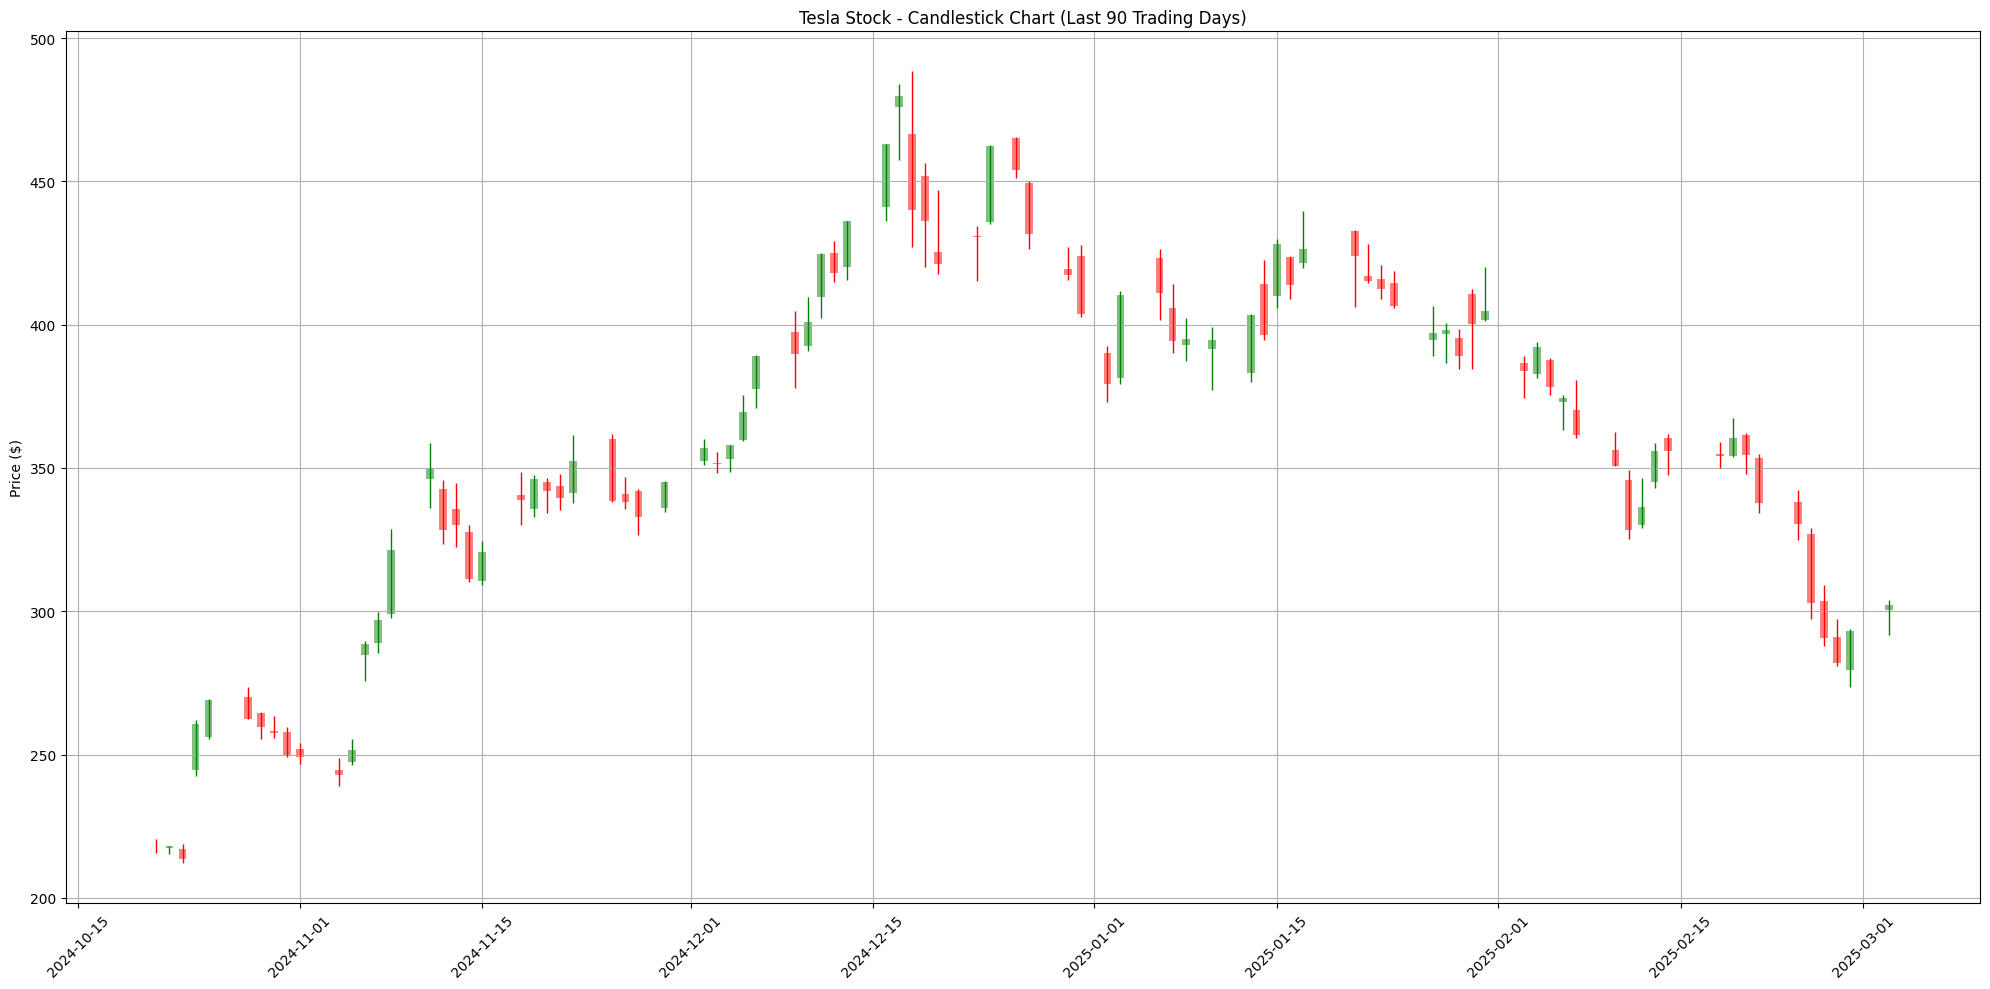

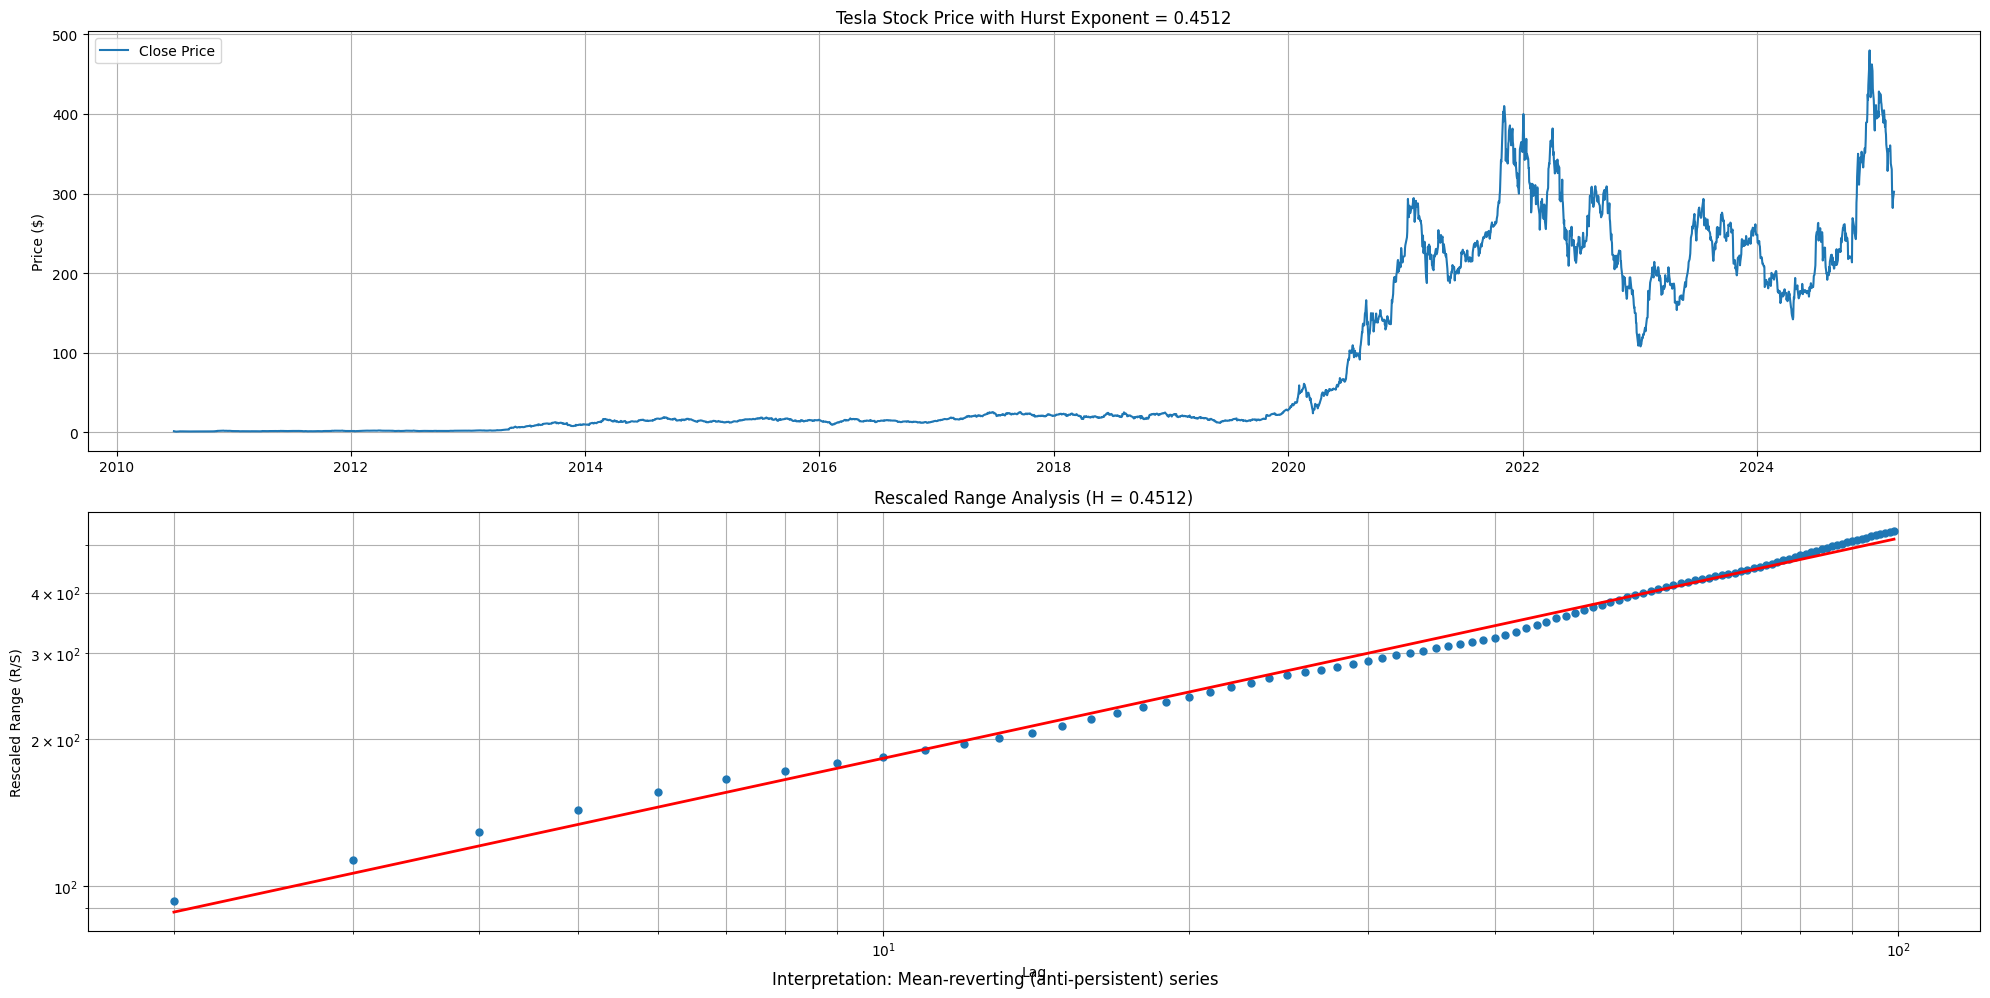


Hurst Exponent: 0.4512


In [29]:
plot_volatility_analysis(df)
plot_candlestick_chart(df, days=90)
hurst_exponent, lags, rs_values = calculate_hurst_exponent(df['close'])
if hurst_exponent is not None:
    plot_hurst_exponent(df, hurst_exponent, lags, rs_values)
    print(f"\nHurst Exponent: {hurst_exponent:.4f}")

# Data Preparation for training

In [30]:
# Data preparation for model
scaler = MinMaxScaler()
# df = df.iloc[1700:, :]
data = scaler.fit_transform(df.iloc[:, :-1].values)

# Create sequences
X, y = create_sequences(data, seq_length)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Split into train, validation, and test sets
# First, determine indices for splitting
test_split_index = X.shape[0] - int(np.round(X.shape[0] * test_size))
val_split_index = test_split_index - int(np.round(X.shape[0] * validation_size))

# Training set
X_train = X[:val_split_index, :, :]
y_train = y[:val_split_index, :]

# Validation set
X_val = X[val_split_index:test_split_index, :, :]
y_val = y[val_split_index:test_split_index, :]

# Test set
X_test = X[test_split_index:, :, :]
y_test = y[test_split_index:, :]

print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Validation shapes: X={X_val.shape}, y={y_val.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}")

X shape: (3512, 180, 4), y shape: (3512, 4)
Train shapes: X=(2458, 180, 4), y=(2458, 4)
Validation shapes: X=(527, 180, 4), y=(527, 4)
Test shapes: X=(527, 180, 4), y=(527, 4)


# Model Building and Training

In [31]:
# Build models
lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]), units)
lstm_model.summary()

rnn_model = build_rnn_model((X_train.shape[1], X_train.shape[2]), units)
rnn_model.summary()

# Dictionary to store training times
training_times = {}

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("Using GPU for training")
    device = '/GPU:0'
else:
    print("Using CPU for training")
    device = '/CPU:0'

set_seeds(seed)
# Train LSTM model with validation data and measure time
with tf.device(device):
    print("\n--- Training LSTM Model ---")
    start_time = time.time()
    lstm_history = lstm_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),  # Added validation data
        verbose=1
    )
    end_time = time.time()
    training_times['LSTM'] = end_time - start_time
    print(f"LSTM training time: {training_times['LSTM']:.2f} seconds")

    # Train RNN model with validation data and measure time
    set_seeds(seed)
    print("\n--- Training RNN Model ---")
    start_time = time.time()
    rnn_history = rnn_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),  # Added validation data
        verbose=1
    )
    end_time = time.time()
    training_times['RNN'] = end_time - start_time
    print(f"RNN training time: {training_times['RNN']:.2f} seconds")


All seeds set to 42 for reproducibility


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 20)                  │           2,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              84 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,084 (8.14 KB)

 Trainable params: 2,084 (8.14 KB)

 Non-trainable params: 0 (0.00 B)

All seeds set to 42 for reproducibility


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 20)                  │             500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │              84 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 584 (2.28 KB)

 Trainable params: 584 (2.28 KB)

 Non-trainable params: 0 (0.00 B)

Using GPU for training
All seeds set to 42 for reproducibility

--- Training LSTM Model ---
Epoch 1/25


2025-04-27 12:16:37.491143: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 2/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.0958e-04 - val_loss: 0.0029
Epoch 3/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6638e-04 - val_loss: 0.0029
Epoch 4/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5931e-04 - val_loss: 0.0019
Epoch 5/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5925e-04 - val_loss: 0.0019
Epoch 6/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8271e-04 - val_loss: 0.0023
Epoch 7/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6364e-04 - val_loss: 0.0032
Epoch 8/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8868e-04 - val_loss: 0.0017
Epoch 9/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8064e-04 - val_loss: 0.0045
Epoch 10/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5958e-04 - val_loss: 0.0016
Epoch 11/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5723e-04 - val_loss: 0.0023
Epoch 12/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8m

2025-04-27 12:16:55.994522: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0101 - val_loss: 0.0781
Epoch 2/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_loss: 0.0299
Epoch 3/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015 - val_loss: 0.0171
Epoch 4/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.1484e-04 - val_loss: 0.0130
Epoch 5/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.3153e-04 - val_loss: 0.0090
Epoch 6/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.8048e-04 - val_loss: 0.0089
Epoch 7/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.9488e-04 - val_loss: 0.0051
Epoch 8/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.2807e-04 - val_loss: 0.0058
Epoch 9/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.8201e-04 - val_loss: 0.0050
Epoch 10/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.3796e-04 - val_loss: 0.0027
Epoch 11/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5575e-04 - val_loss: 0.0035
Epoch 12/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 

# Train and Validation Loss

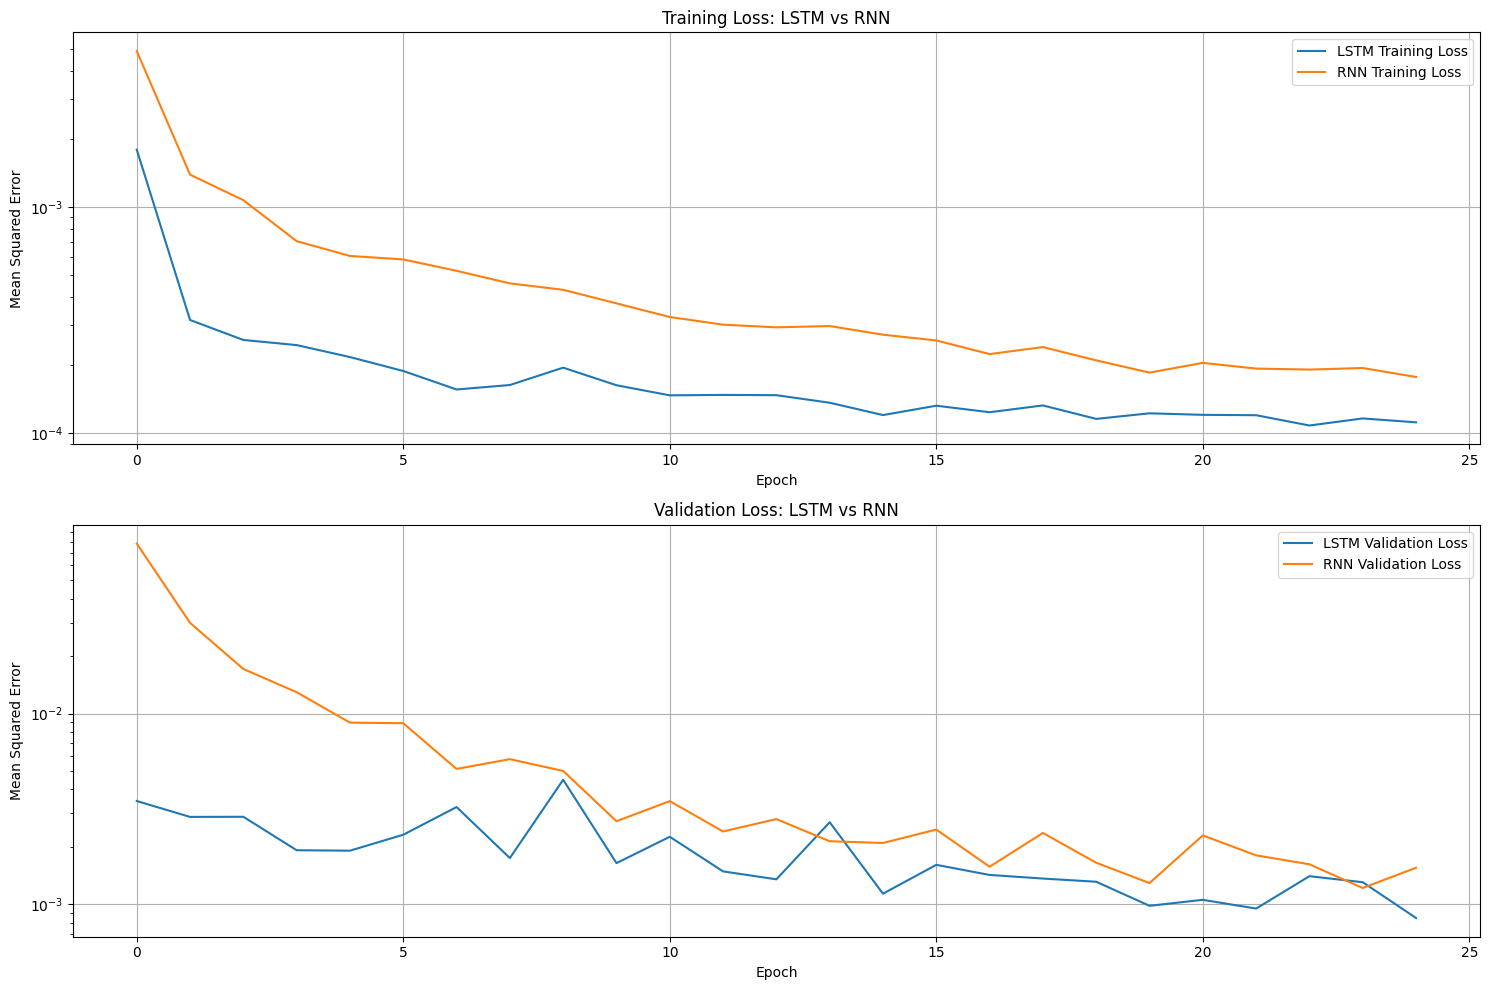

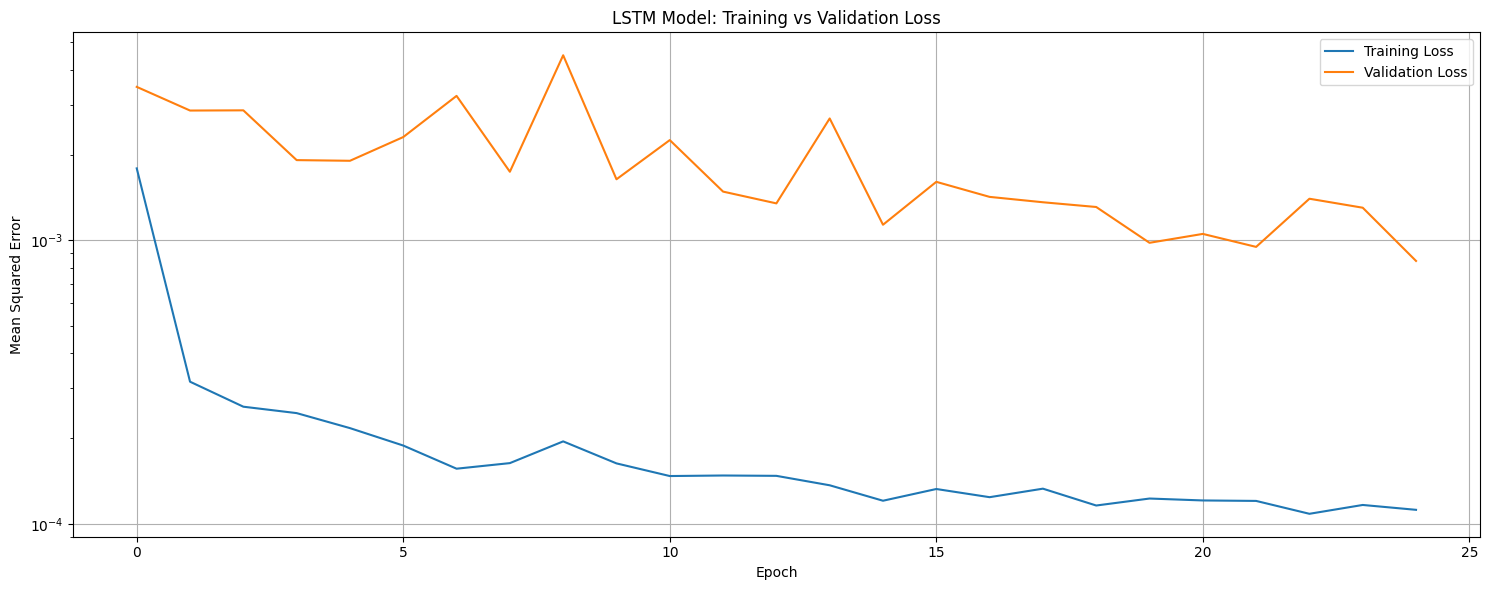

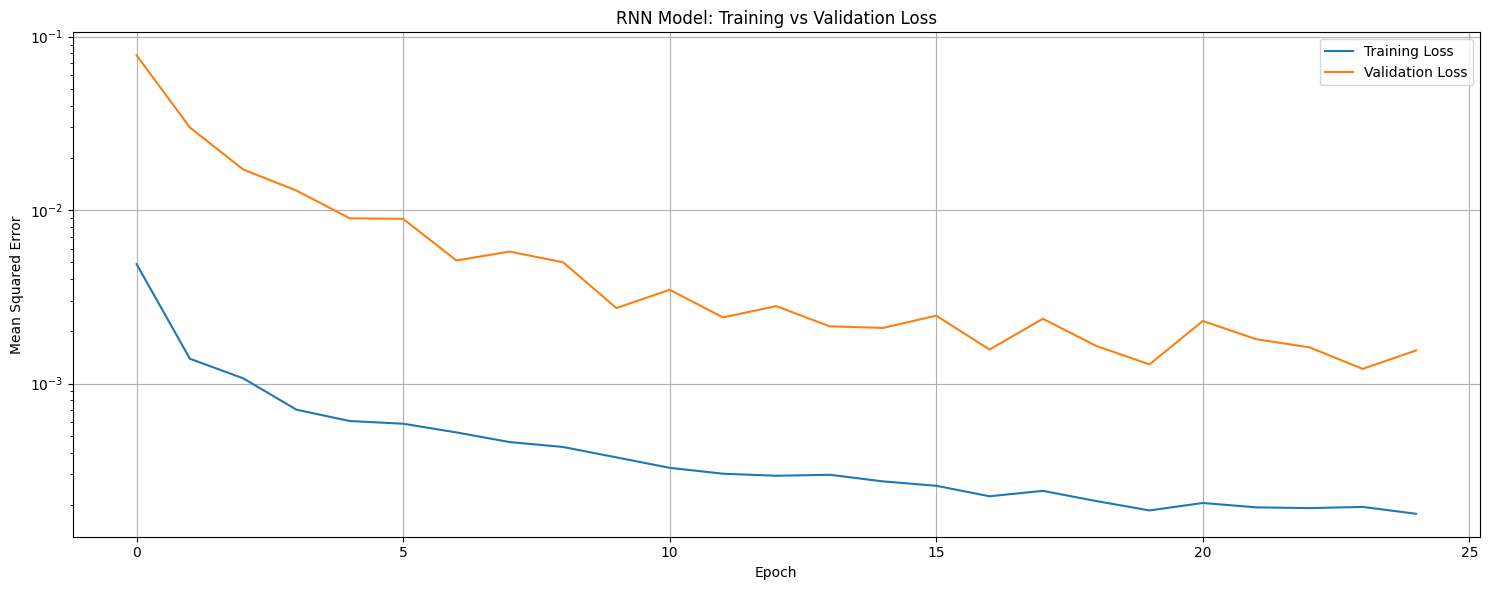

In [32]:
# Plot training history comparison with validation losses
plot_training_history(lstm_history, rnn_history)
plot_individual_training_history(lstm_history, rnn_history)

# Metrics calculation

In [33]:
# Make predictions with both models
lstm_pred_scaled = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

rnn_pred_scaled = rnn_model.predict(X_test)
rnn_pred = scaler.inverse_transform(rnn_pred_scaled)

# Ground truth (actual values)
actual = scaler.inverse_transform(y_test)

# Create DataFrames for predictions
lstm_pred_df = pd.DataFrame(lstm_pred, columns=df.columns[:-1])
lstm_pred_df.index = df.index[seq_length + test_split_index:]

rnn_pred_df = pd.DataFrame(rnn_pred, columns=df.columns[:-1])
rnn_pred_df.index = df.index[seq_length + test_split_index:]


 1/17 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step

2025-04-27 12:17:24.781839: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


<Figure size 1200x800 with 0 Axes>

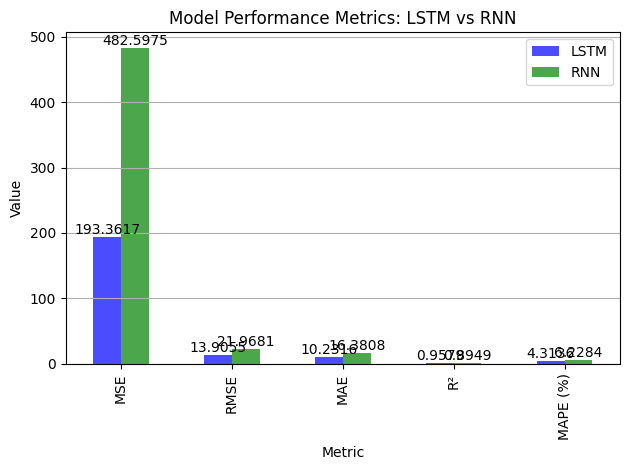


--- Model Performance Comparison ---
                LSTM         RNN
MSE       193.361678  482.597484
RMSE       13.905455   21.968101
MAE        10.231643   16.380817
R²          0.957888    0.894895
MAPE (%)    4.313607    6.228384

--- Detailed Comparison ---
                LSTM         RNN  Improvement (%) Better Model
MSE       193.361678  482.597484        59.933136         LSTM
RMSE       13.905455   21.968101        36.701608         LSTM
MAE        10.231643   16.380817        37.538868         LSTM
R²          0.957888    0.894895         7.039125         LSTM
MAPE (%)    4.313607    6.228384        30.742757         LSTM


/tmp/ipykernel_31/1225896678.py:286: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  better_model = ['LSTM' if metrics['LSTM'][i] < metrics['RNN'][i] else 'RNN' for i in range(len(metrics))]
/tmp/ipykernel_31/1225896678.py:291: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  better_model[idx] = 'LSTM' if metrics['LSTM'][idx] > metrics['RNN'][idx] else 'RNN'


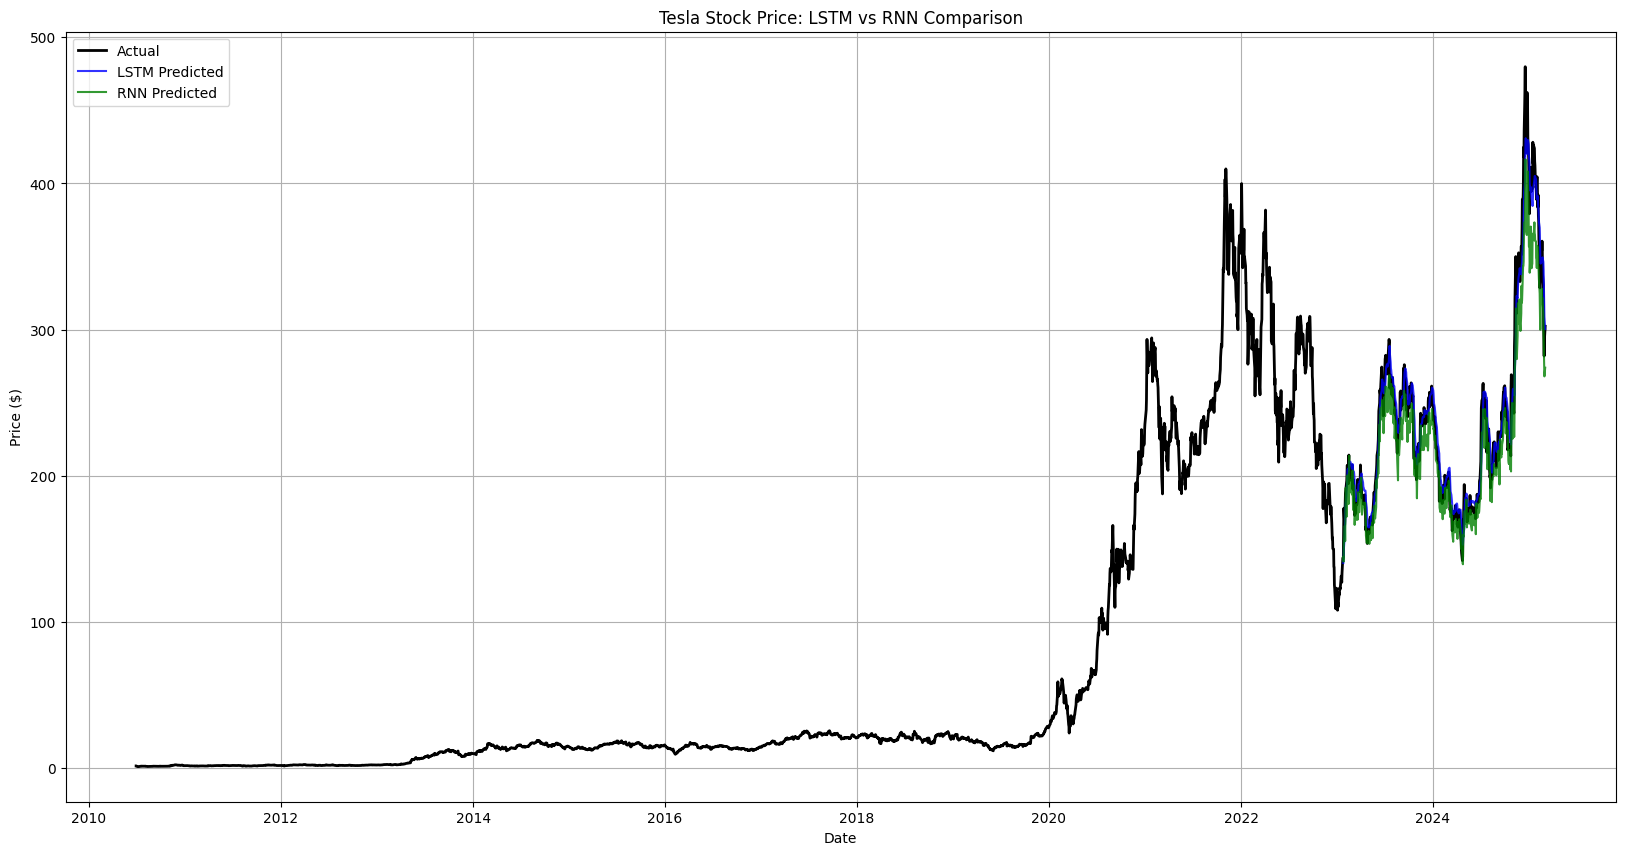

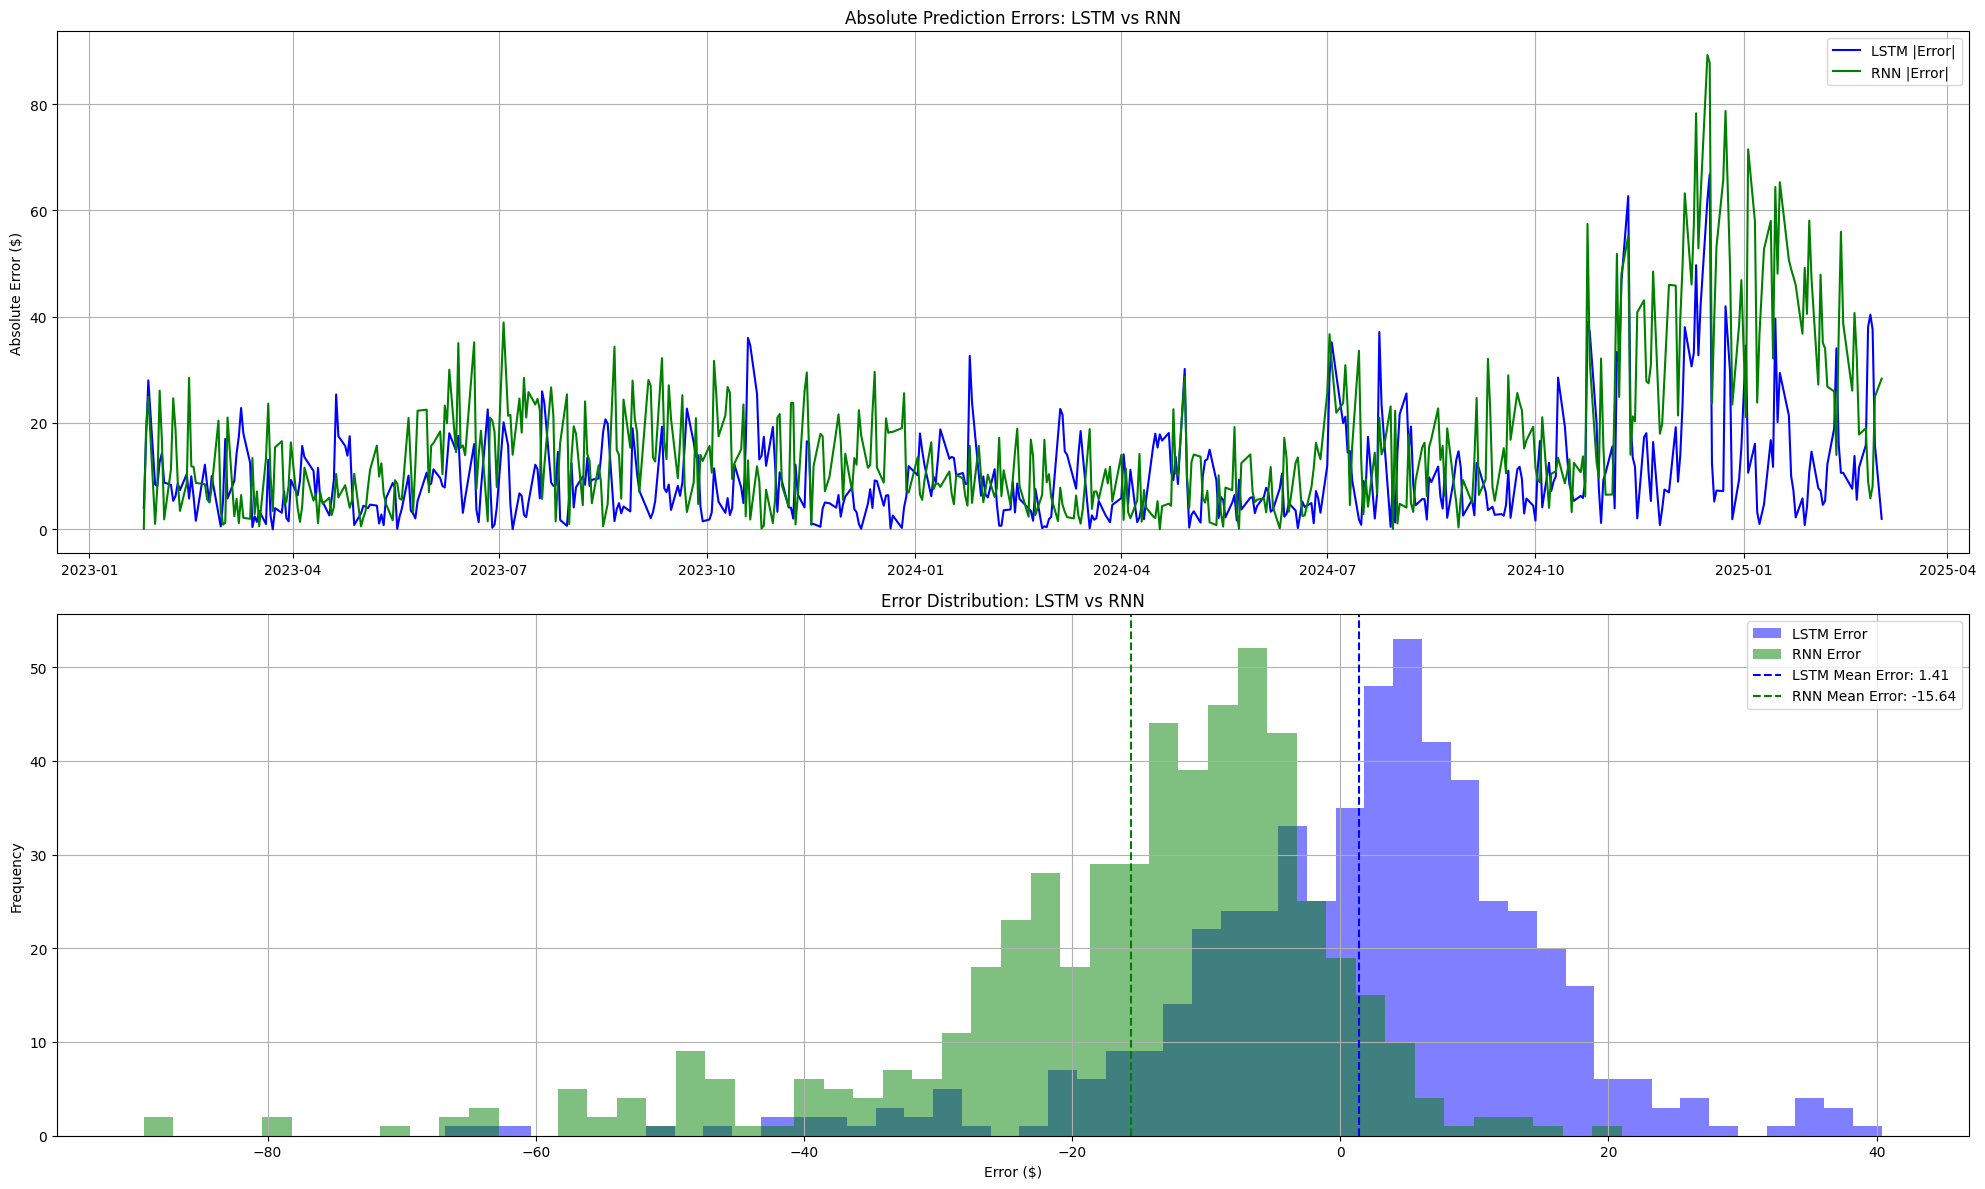

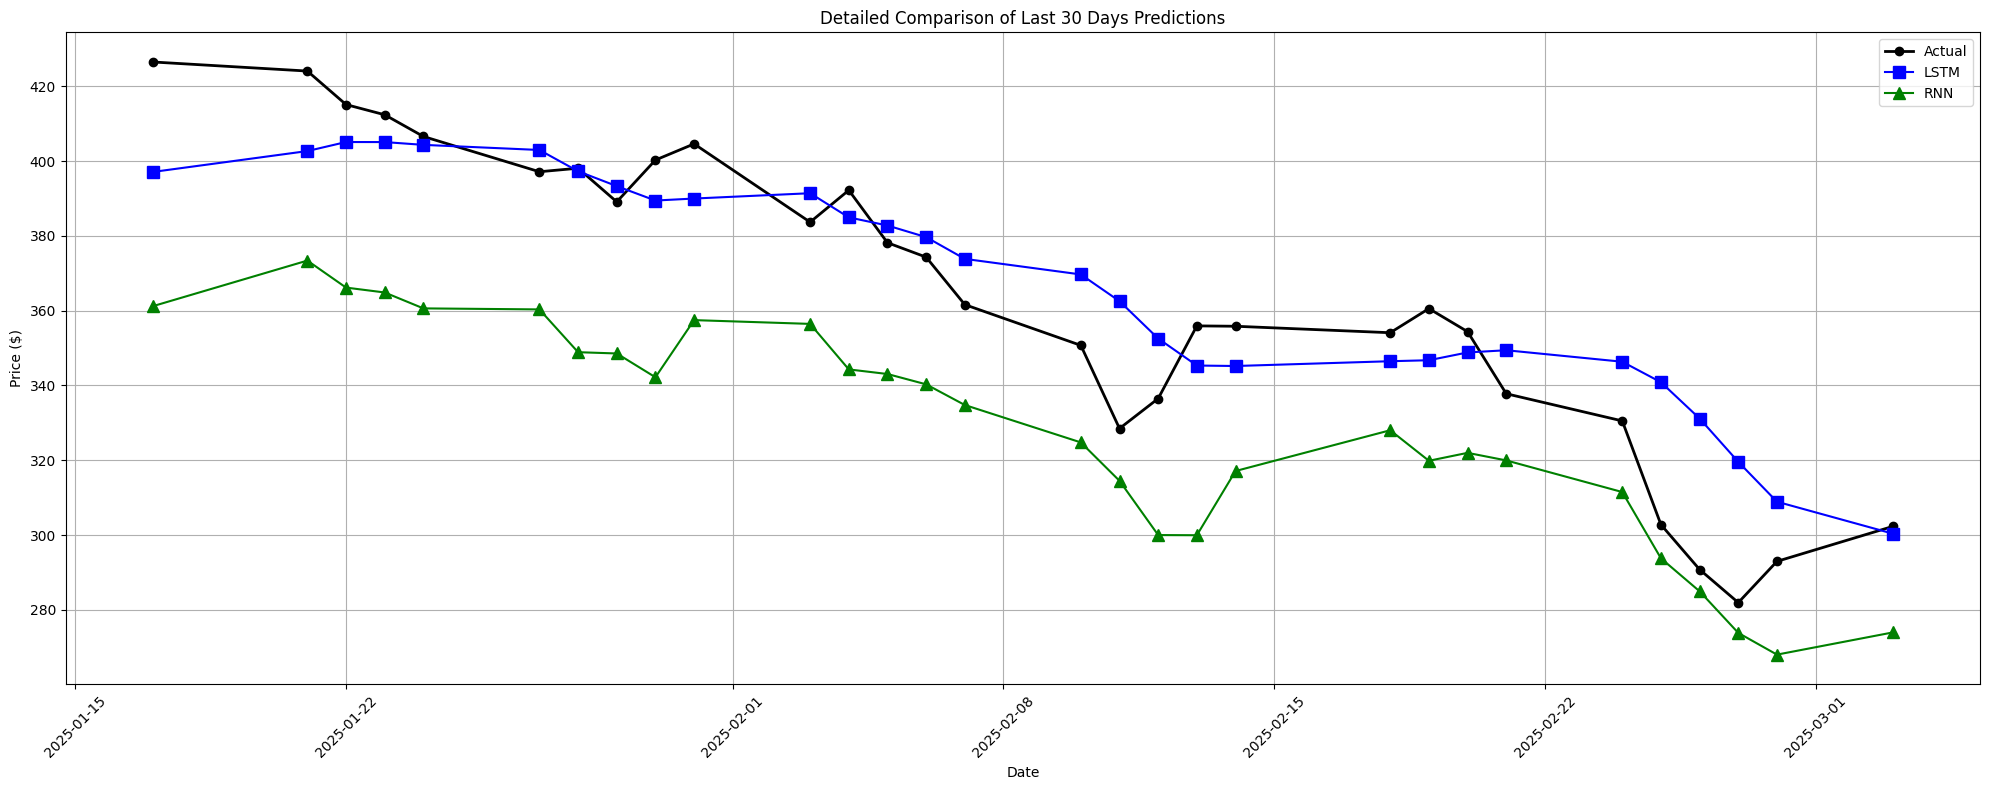

In [34]:
# Calculate and compare performance metrics
lstm_metrics = calculate_metrics(actual[:, 0], lstm_pred[:, 0])  # Using only 'close' column
rnn_metrics = calculate_metrics(actual[:, 0], rnn_pred[:, 0])    # Using only 'close' column

compare_model_metrics(lstm_metrics, rnn_metrics)

# Plot prediction comparisons
plot_model_comparison(df, lstm_pred_df, rnn_pred_df)
plot_error_comparison(df, lstm_pred_df, rnn_pred_df)
plot_close_predictions_detail(df, lstm_pred_df, rnn_pred_df, window_size=30)


# Model Training


--- Generating Forecasts ---


2025-04-27 12:17:29.837386: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


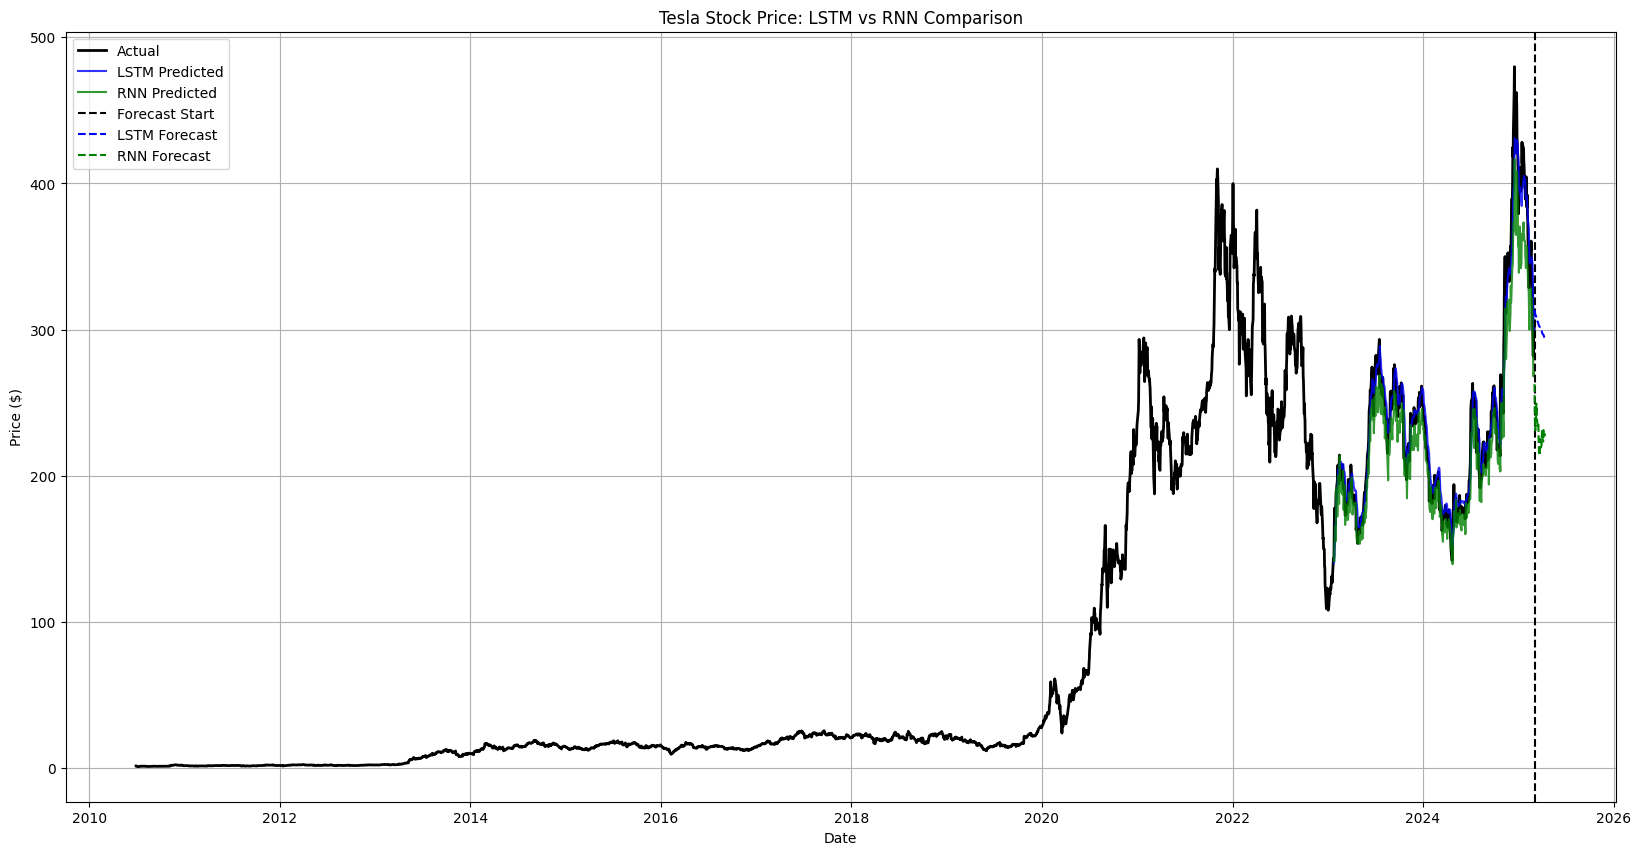

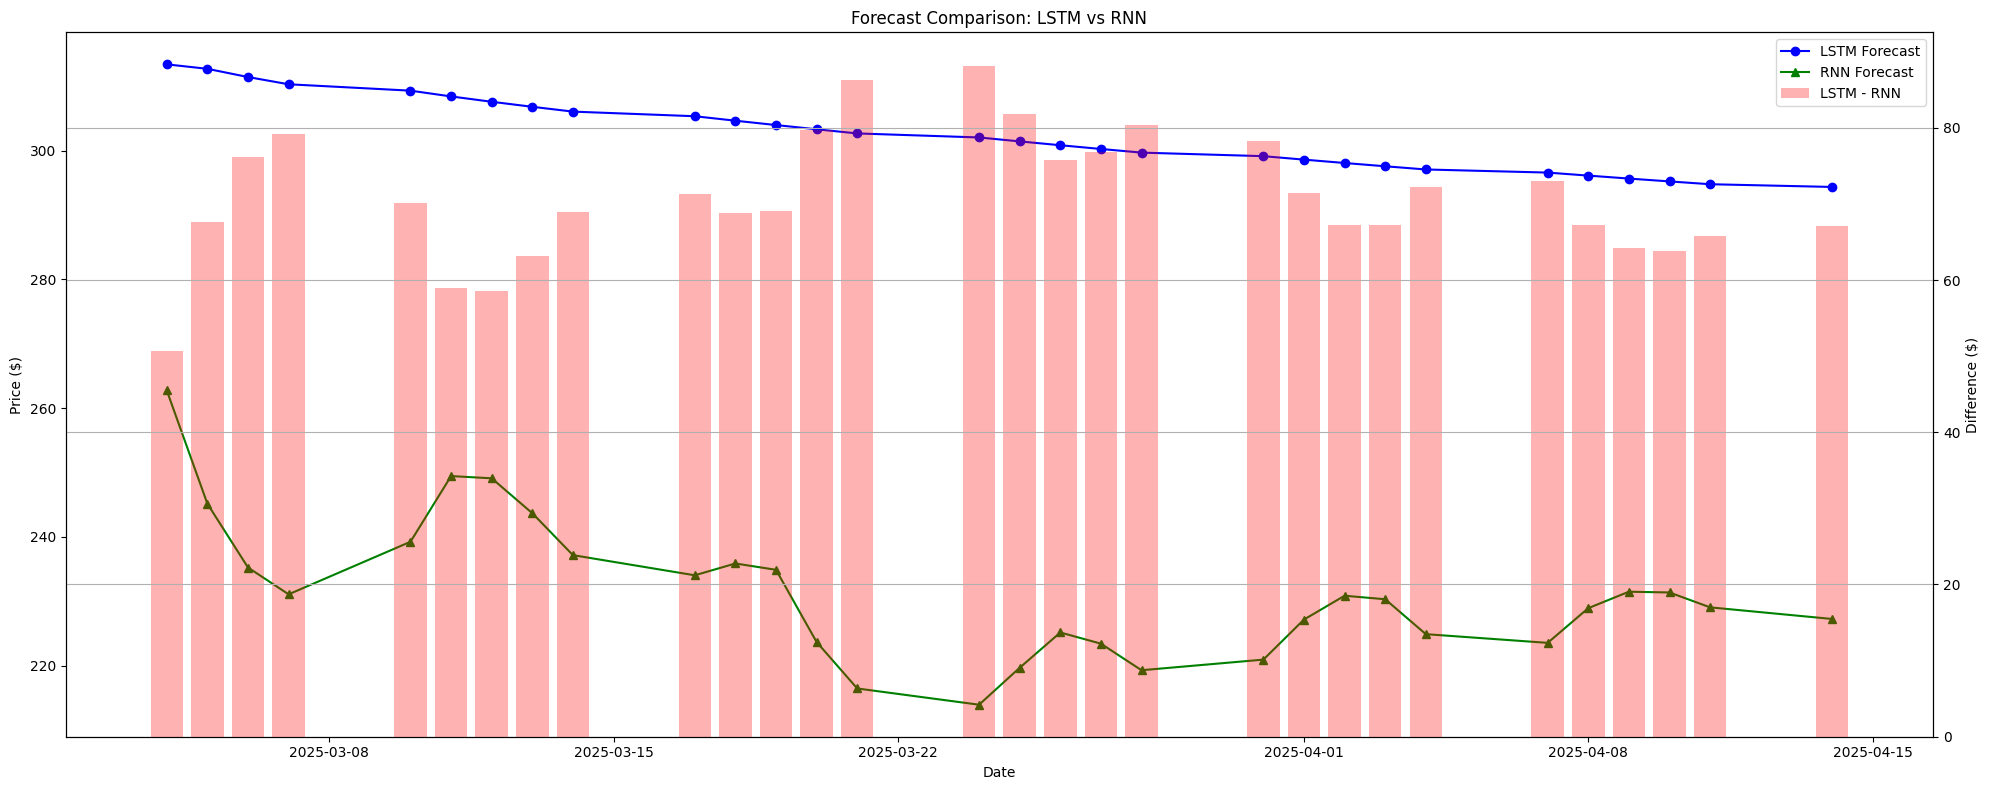

In [35]:
# Generate forecasts with both models
last_sequence = scaler.transform(lstm_pred_df.values[-seq_length:])
future_start_date = '2025/3/4'

print("\n--- Generating Forecasts ---")
lstm_forecast = forecast_future(
    lstm_model,
    last_sequence,
    scaler,
    days_to_predict,
    seq_length,
    X_train.shape[2],
    future_start_date
)
lstm_forecast.columns = df.columns[:-1]

rnn_forecast = forecast_future(
    rnn_model,
    last_sequence,
    scaler,
    days_to_predict,
    seq_length,
    X_train.shape[2],
    future_start_date
)
rnn_forecast.columns = df.columns[:-1]

# Plot forecasts comparison
plot_model_comparison(df, lstm_pred_df, rnn_pred_df, lstm_forecast, rnn_forecast)
plot_forecast_comparison(lstm_forecast, rnn_forecast)


# Forecast Results

In [36]:
# Print forecast results
print("\n--- LSTM Forecast Results ---")
print(lstm_forecast[['open', 'close']].head())
print(f"LSTM forecast ending price: ${lstm_forecast['close'].iloc[-1]:.2f}")
lstm_forecast_change = (lstm_forecast['close'].iloc[-1] - df['close'].iloc[-1]) / df['close'].iloc[-1] * 100
print(f"LSTM percentage change from last known price: {lstm_forecast_change:.2f}%")

print("\n--- RNN Forecast Results ---")
print(rnn_forecast[['open', 'close']].head())
print(f"RNN forecast ending price: ${rnn_forecast['close'].iloc[-1]:.2f}")
rnn_forecast_change = (rnn_forecast['close'].iloc[-1] - df['close'].iloc[-1]) / df['close'].iloc[-1] * 100
print(f"RNN percentage change from last known price: {rnn_forecast_change:.2f}%")

# Final comparison summary
print("\n--- Model Comparison Summary ---")
print(f"LSTM training time: {training_times['LSTM']:.2f} seconds")
print(f"RNN training time: {training_times['RNN']:.2f} seconds")
print(f"Training time difference: {(training_times['LSTM'] - training_times['RNN']):.2f} seconds")

# Validation performance
lstm_val_loss = lstm_history.history['val_loss'][-1]
rnn_val_loss = rnn_history.history['val_loss'][-1]
print(f"Final LSTM validation loss: {lstm_val_loss:.6f}")
print(f"Final RNN validation loss: {rnn_val_loss:.6f}")
print(f"Validation loss difference: {(lstm_val_loss - rnn_val_loss):.6f}")

forecast_diff = (lstm_forecast['close'].iloc[-1] - rnn_forecast['close'].iloc[-1])
forecast_diff_pct = (forecast_diff / rnn_forecast['close'].iloc[-1]) * 100
print(f"Final forecast difference: ${forecast_diff:.2f} ({forecast_diff_pct:.2f}%)")

# Determine which model performed better overall
mse_better = "LSTM" if lstm_metrics["MSE"] < rnn_metrics["MSE"] else "RNN"
r2_better = "LSTM" if lstm_metrics["R²"] > rnn_metrics["R²"] else "RNN"
val_better = "LSTM" if lstm_val_loss < rnn_val_loss else "RNN"

print(f"Based on MSE, {mse_better} performed better")
print(f"Based on R², {r2_better} performed better")
print(f"Based on validation loss, {val_better} performed better")

print("\nAnalysis complete")


--- LSTM Forecast Results ---
                  open       close
2025-03-04  305.206801  313.408593
2025-03-05  304.998585  312.714608
2025-03-06  304.300240  311.437369
2025-03-07  303.586414  310.313242
2025-03-10  302.870353  309.321537
LSTM forecast ending price: $294.36
LSTM percentage change from last known price: -2.64%

--- RNN Forecast Results ---
                  open       close
2025-03-04  301.854378  262.739104
2025-03-05  298.484549  245.139583
2025-03-06  288.026386  235.230579
2025-03-07  275.592508  231.065825
2025-03-10  283.168113  239.232004
RNN forecast ending price: $227.24
RNN percentage change from last known price: -24.84%

--- Model Comparison Summary ---
LSTM training time: 18.51 seconds
RNN training time: 27.13 seconds
Training time difference: -8.62 seconds
Final LSTM validation loss: 0.000845
Final RNN validation loss: 0.001551
Validation loss difference: -0.000706
Final forecast difference: $67.12 (29.54%)
Based on MSE, LSTM performed better
Based on R²

## Conclusion

This analysis demonstrates the application of recurrent neural networks to financial time series forecasting, specifically comparing LSTM and RNN architectures.

Key findings:
- LSTM vs RNN performance differences in terms of accuracy and training time
- The impact of model architecture on forecasting quality
- The challenges of multi-step recursive forecasting, the error keeps getting propagated and the predictions fails to retain their statistical significance

Limitations and future work:

- Testing more advanced architectures (Transformer models, attention mechanisms)
- Ensemble methods to combine multiple forecasts
- Hyperparameter optimization
- Exploring longer forecast horizons and their reliability




## Configuration Parameters

The analysis uses the following configuration parameters:

- **seq_length = 180**: Number of days in each input sequence
- **units = 20**: Number of neurons in the recurrent layers
- **batch_size = 32**: Number of samples per gradient update
- **epochs = 25**: Number of complete passes through the training dataset
- **days_to_predict = 30**: Forecast horizon in days
- **test_size = 0.15**: Proportion of data used for testing
- **validation_size = 0.15**: Proportion of data used for validation
- **n_steps_ma = 10**: Window size for moving average calculation

These parameters can be adjusted to experiment with different model configurations.